# Meridional Heat Transport

## (MOM5) 

This recipe calculates the model's meridional heat transport (MHT) using two methods based on distinct MOM5 diagnostics. The methods and the caveats associated with them are listed below:

### Method 1: Using online diagnostics

This is the recommended method. In MOM5 the meridional heat transported associated to resolved advection is given by the `temp_yflux_adv_int_z`. The heat fluxes associated to parametrised processes are provided in separate diagnostics (like `temp_yflux_gm` and `temp_yflux_ndiffuse` for the mesoscale parametrisations and `temp_yflux_submeso` for the submesoscale parametrisations).

This recipe uses ACCESS-OM2-01, which does not have mesoscale parametrisations (and therefore no `temp_yflux_gm` or `temp_yflux_ndiffuse`). We further assume the heat flux due to submesoscale parametrisation (`temp_yflux_submeso`) is small and that the bulk of the meridional heat flux is due to resolved advection `temp_yflux_adv_int_z`.  

### Method 2: Using surface and frazil heat fluxes

This is an alternative method that approximates the meridional heat transport from surface heat fluxes for the simulations in which the online diagnostics needed in Method 1 are not available. Note that this method relies on a steady state assumption. We use two diagnostics: `net_sfc_heating` (net surface heat flux) and `frazil_3d_int_z` which is the heat flux due to frazil formation at higher latitudes.
  
The recipe calculates the total (all basins) MHT, and it also includes comparisons to a few observational products. Basin-specific MHT can be calculated by defining relevant masks.

## Information needed to adapt to MOM6

The diagnostics for meridional heat transports are called `T_ady_2d` (from resolved advection), `T_diffy_2d` (from diffusion) and `hfds` for the surface heat flux (includes frazil contribution).

## MOM5 recipe

In [1]:
import intake

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

from dask.distributed import Client
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

Start dask cluster.

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40295,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35649,Total threads: 1
Dashboard: /proxy/37953/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:40125,


Load ACCESS-NRI default catalog

In [3]:
catalog = intake.cat.access_nri

Define experiment of interest

In [4]:
experiment = '01deg_jra55v140_iaf_cycle3'
start_time = '2000-01-01'
end_time = '2005-12-31'

We are now ready to load the data to start our analysis. We load `temp_yflux_adv_int_z`. For this example, we have chosen to use 6 years of output.

## Method 1: Using online diagnostics

In [5]:
ds_adv = catalog[experiment].search(variable = ['temp_yflux_adv_int_z'], frequency='1mon').to_dask(xarray_open_kwargs={"decode_timedelta": True})
ds_adv = ds_adv['temp_yflux_adv_int_z'].sel(time=slice(start_time, end_time))
ds_adv

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 2700,
                                          xt_ocean: 3600)> Size: 3GB
dask.array<getitem, shape=(72, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * time      (time) datetime64[ns] 576B 2000-01-16T12:00:00 ... 2005-12-16T1...
Attributes:
    long_name:      z-integral of cp*rho*dxt*v*temp
    units:          Watts
    valid_range:    [-1.e+18  1.e+18]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

We convert the dataset from Watts (W) to PetaWatts (PW).

In [6]:
ds_adv = ds_adv * 1e-15
ds_adv.attrs['units'] = 'PetaWatts'
ds_adv

<xarray.DataArray 'temp_yflux_adv_int_z' (time: 72, yu_ocean: 2700,
                                          xt_ocean: 3600)> Size: 3GB
dask.array<mul, shape=(72, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
  * time      (time) datetime64[ns] 576B 2000-01-16T12:00:00 ... 2005-12-16T1...
Attributes:
    units:    PetaWatts

and then we compute the mean across `time` and sum over all longitudes.

In [7]:
MHT_method_1 = ds_adv.mean('time').sum('xt_ocean')

## Method 2: Using surface and frazil heat fluxes 

First, we load the surface heat flux and grid metrics:

In [8]:
ds_sfc = catalog[experiment].search(variable = ['net_sfc_heating'], frequency='1mon').to_dask(xarray_open_kwargs={"decode_timedelta": True})
ds_sfc = ds_sfc['net_sfc_heating'].sel(time=slice(start_time, end_time))
ds_sfc

<xarray.DataArray 'net_sfc_heating' (time: 72, yt_ocean: 2700, xt_ocean: 3600)> Size: 3GB
dask.array<getitem, shape=(72, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 576B 2000-01-16T12:00:00 ... 2005-12-16T1...
Attributes:
    long_name:      surface ocean heat flux coming through coupler and mass t...
    units:          Watts/m^2
    valid_range:    [-10000.  10000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [9]:
ds_frz = catalog[experiment].search(variable = ['frazil_3d_int_z'], frequency='1mon').to_dask(xarray_open_kwargs={"decode_timedelta": True})
ds_frz = ds_frz['frazil_3d_int_z'].sel(time=slice(start_time, end_time))
ds_frz

<xarray.DataArray 'frazil_3d_int_z' (time: 72, yt_ocean: 2700, xt_ocean: 3600)> Size: 3GB
dask.array<getitem, shape=(72, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 576B 2000-01-16T12:00:00 ... 2005-12-16T1...
Attributes:
    long_name:      Vertical sum of ocn frazil heat flux over time step
    units:          W/m^2
    valid_range:    [-1.e+10  1.e+10]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

Add the heat fluxes and take the `time` mean:

In [10]:
shflux = (ds_sfc + ds_frz).mean('time').load()

In [11]:
# Get the relevant grid_info
area = catalog[experiment].search(variable='area_t', frequency='fx').to_dask()['area_t']
geolat_t = catalog[experiment].search(variable='geolat_t', frequency='fx').to_dask()['geolat_t']
geolon_t = catalog[experiment].search(variable='geolon_t', frequency='fx').to_dask()['geolon_t']

In [12]:
# Add geolat_t and geolon_t coords
area = area.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
shflux = shflux.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})

Now calculate Meridional Heat Flux (MHF). This is done by calculating the total heat flux as the heat flux times the area, and then integrating in latitude space such that for each latitude:

$$
\mathrm{MHF}(y) = \int_{y_{0}}^{y} (\mathrm{SHFLUX} \times \mathrm{AREA}) \, \mathrm{d}y
$$

In [13]:
# Create left edge for bottom bin
latv_bins = np.hstack(([-90], area['yt_ocean'].values))

MHT = shflux * area
MHT = MHT.groupby_bins('geolat_t', latv_bins)
MHT = MHT.sum()
MHT = MHT.cumsum()
MHT = MHT.rename(geolat_t_bins='yt_ocean')
MHT.coords['yt_ocean'] = area['yt_ocean']

MHT_method_2 = MHT + (MHT.isel(yt_ocean=0) - MHT.isel(yt_ocean=-1)) / 2

# Convert to petawatt
MHT_method_2 = MHT_method_2 * 1e-15
MHT_method_2.attrs['units'] = 'PetaWatts'

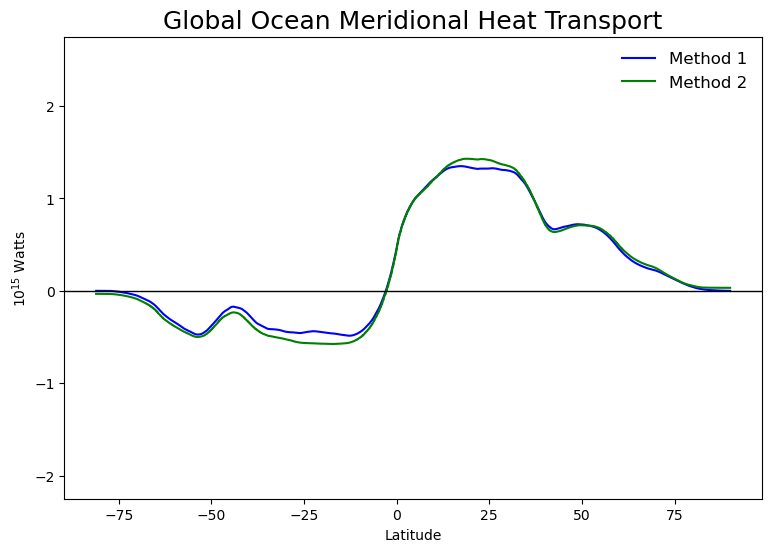

In [14]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

MHT_method_1.plot(ax = ax, color = 'blue', label = 'Method 1')
MHT_method_2.plot(ax = ax, color = 'green', label = 'Method 2')

# add legend
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')

# limits along the y axis
plt.ylim(-2.25, 2.75)

# add titles and labels
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('$10^{15}$ Watts');

## Comparison between model output and observations

The following section compares the model's heat transport to observations. These observations are derived using various methods, in particular using surface flux observations a la method 2 (which assumes a steady state).

### Read ERBE Period Ocean and Atmospheric Heat Transport

This data comes (annoyingly) in a text file. The cell below opens and saves latitudes and heat transport into two separate lists: 

In [15]:
# Path to the file containing observations
filename = '/g/data3/ik11/from_hh5_tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

# Create empty variables to store our observations
erbe_MHT = []
erbe_lat = []

# Open data and save it to empty variables above
with open(filename) as f:
    #Open each line from rows 1 to 96
    for line in f.readlines()[1:96]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting latitude and MHT and saving to empty variables
        erbe_lat.append(float(sline[0]))
        erbe_MHT.append(float(sline[3]))

### Read NCEP and ECMWF Oceanic and Atmospheric Transport Products

These datasets are available at https://climatedataguide.ucar.edu/climate-data. We use a climatological mean of surface fluxes or vertically integrated total energy divergence for oceanic and atmospheric transports respectively for the period between February 1985 - April 1989.

This also comes as a text file and again, we will save it into lists. There is also an estimate of the observational error:

In [16]:
#Path to the file containing observations
filename = '/g/data/ik11/observations/ANNUAL_TRANSPORTS_1985_1989.ascii'

#Creating empty variables to store our observations
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
#Open each line in file (ignoring the first row)
    for line in f.readlines()[1:]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting values and saving to correct variable defined above
        o_lat.append(float(sline[0]) * 0.01)         # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4]) * 0.01)    # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5]) * 0.01)   # Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7]) * 0.01)    # Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8]) * 0.01)    # Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9]) * 0.01)    # Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10]) * 0.01)   # Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11]) * 0.01)   # Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12]) * 0.01)   # Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13]) * 0.01)   # Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15]) * 0.01)  # Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16]) * 0.01)  # Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17]) * 0.01)  # Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18]) * 0.01)  # Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19]) * 0.01)  # Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20]) * 0.01)  # Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21]) * 0.01)  # Error Bars for NCEP Indian Transports

#Calculating MHT
ncep_ip_mht  = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err  = [max(a, b) for a, b in zip(ncep_p_err, ncep_i_err)]
ecwmf_ip_err = [max(a, b) for a, b in zip(ecwmf_p_err, ecwmf_i_err)]

## Plotting model outputs against observations

We plot the global meridional heat transport as calculated from model outputs (blue line) and observations.

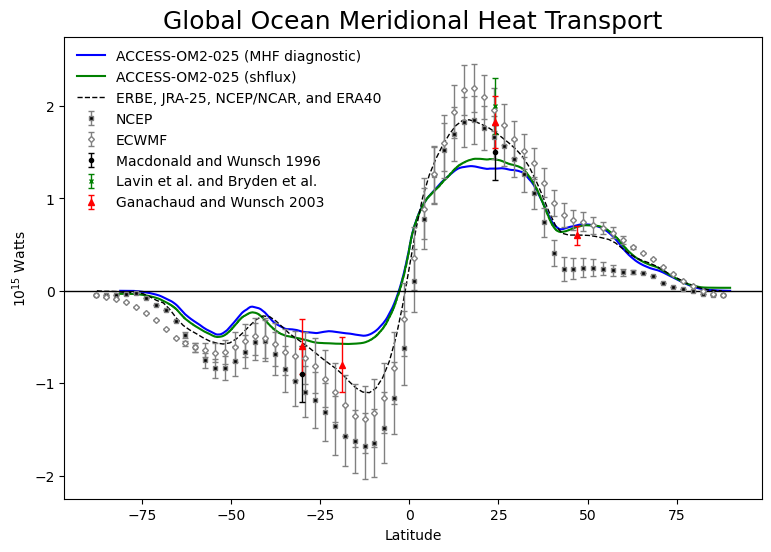

In [19]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)

#Plotting MHT from model outputs
MHT_method_1.plot(ax = ax, color = "blue", label = "ACCESS-OM2-025 (MHF diagnostic)")
MHT_method_2.plot(ax = ax, color = "green", label = "ACCESS-OM2-025 (shflux)")

#Adding observations and error bars for observations
ax.plot(erbe_lat, erbe_MHT, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR, and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")
plt.errorbar( 24,  1.5, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1,
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9, yerr=0.3, fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar( 24,  2.0, yerr=0.3, fmt='x', c='green', markersize=3, capsize=2, linewidth=1,
             label="Lavin et al. and Bryden et al.")
plt.errorbar( 24,  1.83, yerr=0.28, fmt='^', c='red', markersize=4, capsize=2, linewidth=1,
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8, yerr=0.3, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)
plt.errorbar( 47,  0.6, yerr=0.1, fmt='^', c='red', markersize=4, capsize=2, linewidth=1)

# add legend
plt.legend(frameon=False, fontsize=10)
plt.axhline(y=0, linewidth=1, color='black')

# limits along the y axis
plt.ylim(-2.25, 2.75)

# add titles and labels
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('$10^{15}$ Watts');

In [18]:
client.close()